In [320]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import scipy
import time
from IPython.display import HTML

mpl.rcParams['animation.embed_limit'] = 1000  # Limite en Mo, ici 1000 Mo

### Fonctions de rayonnement

In [315]:
#Rayonnement
def soleil(saison):
    '''Renvoie les données de flux solaire (watt/m2) par pas horaire sur une journée complète (minuit-minuit heure solaire).

    Paramètres :
    saison : Chaine de caractères 'été' ou 'hiver'
    '''
    if saison == 'été': #minuit-minuit heure solaire = 2h-2h heure locale
        fluxsoleil = np.array([0,0,0,50,200,400,600,750,850,920,950,940,
                                 900,800,650,500,300,120,50,10,0,0,0,0])
    elif saison == 'hiver': #minuit-minuit heure solaire = 1h-1h heure locale
        fluxsoleil = np.array([0,0,0,0,0,0,0,0,100,250,420,490,
                               480,400,250,100,0,0,0,0,0,0,0,0])

    return fluxsoleil

def interpol_soleil(saison, t_init, dt, nt):
    '''
    Interpole le flux solaire à la fréquence temporelle du modèle,
    y compris pour une simulation à cheval sur deux jours.
    
    Paramètres :
    - saison : paramètre pour la fonction `soleil(saison)`
    - t_init : heure de début en heures (ex : 20)
    - dt     : pas de temps en secondes
    - nt     : nombre total de pas de temps
    '''

    # Base temporelle en heures pour 2 jours (0 à 47)
    heures_base = np.arange(0, 48)  # 0h à 47h

    # Convertir en secondes
    t_base = heures_base * 3600

    # Créer flux solaire sur 2 jours (en concaténant 2 jours identiques ici)
    flux_24h = soleil(saison)
    flux_48h = np.concatenate([flux_24h, flux_24h])  # réplication simplifiée

    # Vecteur temps voulu
    t_debut = t_init * 3600  # conversion en secondes
    t_fin = t_debut + dt * nt
    t_new = np.arange(t_debut, t_fin + dt, dt)

    # Interpolation
    func_interpol = scipy.interpolate.interp1d(t_base, flux_48h, kind='linear', fill_value="extrapolate")

    return func_interpol(t_new)
    

def flux_infrarouge(emissivite, theta_sol, p_surf_atmo, Rd, cp, sigma):
    '''Renvoie l'énergie émise (perdue) par un objet. Par exemple : le sol terrestre, ou un nuage

    Paramètres :
    emmissivite : nombre réel entre 0 et 1. Grandeur sans dimension propre à l'objet modulant sa facilité à émettre du rayonnement infrarouge   
    T : nombre réel. Température en degré Kelvin
    p_surf_atmo : pression du 1er niveau d'atmosphère
    theta_sol : température potentielle du sol
    ...
    '''
    T = exner(p_surf_atmo, Rd, cp, pref=1e5) * theta_sol
    return emissivite * sigma * T**4 

def albedo_effectif_nuage(q_l, albedo, albedo_cloud=0.6):
    """
    Calcule l'albédo effectif en tenant compte de la couverture nuageuse.
    
    C : fraction nuageuse [0-1]
    alpha_surface : albédo de la surface (ex : 0.2 pour sol sableux)
    alpha_cloud : albédo typique des nuages (par défaut 0.6)
    
    Retour : albedo effectif
    """
    C = np.sum(fraction_nuageuse_ql(q_l, ql_max=0.0003), axis=-1)
    return (1 - C) * albedo + C * albedo_cloud

### Couplage surface - atmosphère

In [316]:
def flux_sensible_surface(theta, theta_sol, Ksurf, cp, rho_atmo_surf, dz):
    ''' Calcule le transfert de chaleur direct entre le sol et l'atmosphère'''
    return Ksurf * (theta[:,0] - theta_sol) / dz

def flux_evaporation_surface(Ksurf, p_surf_atmo, rho_surf_atmo, theta_sol, Rd, cp, q, q_sol, rho_sol, cp_sol, dz_sol, dz):
    ''' Calcule le transfert d'humidité entre le sol et l'atmosphère'''
    qs_sol = q_sat(p_surf_atmo, theta_sol, Rd, cp)
    flux_evaporation =  Ksurf * (q[:,0] - qs_sol) / dz  #m/s
    tendance_potentiel_q_sol =  rho_surf_atmo * flux_evaporation / (rho_sol * dz_sol * dz)
    #verifie que q_sol reste positif
    q_sol_negatif = q_sol + tendance_potentiel_q_sol
    q_sol_negatif = (q_sol_negatif - np.abs(q_sol_negatif) ) / 2
    flux_evaporation =  flux_evaporation - q_sol_negatif * (rho_sol * dz_sol * dz) / rho_surf_atmo
    return flux_evaporation

def rayonnement_net_surface(q_l, fluxsoleil, albedo, emissivite, theta_sol, p_surf_atmo, Rd, cp, sigma, Teff):
    ''' Calcule le biland radiatif net au sol (= chauffage du sol le jour / refroidissement du sol la nuit)'''
    ir_montant = flux_infrarouge(emissivite, theta_sol, p_surf_atmo, Rd, cp, sigma)
    ir_descendant = 1 * sigma * Teff**4
    bilan_ir = ir_descendant - ir_montant
    # print('nuage', effet_nuage)
    return (1-albedo) * fluxsoleil + bilan_ir

def update_surface(theta, theta_sol, q, q_sol, q_l, Lv, cp, Ksurf, dz, fluxsoleil, albedo, emissivite, Rd, sigma, p_surf_atmo, rho_surf_atmo, rho_sol, cp_sol, dz_sol, Teff):
    ''' Met à jour les variables du modèle de surface (température potentielle, humidité) sous l'effet de l'intéraction avec l'atmosphère.'''
    flux_sensible = flux_sensible_surface(theta, theta_sol, Ksurf, cp, rho_surf_atmo, dz)
    flux_evaporation = flux_evaporation_surface(Ksurf, p_surf_atmo, rho_surf_atmo, theta_sol, Rd, cp, q, q_sol, rho_sol, cp_sol, dz_sol, dz)
    albedo_effectif = albedo_effectif_nuage(q_l, albedo, albedo_cloud=0.6)
    rayonnement_net = rayonnement_net_surface(q_l, fluxsoleil, albedo_effectif, emissivite, theta_sol, p_surf_atmo, Rd, cp, sigma, Teff)
    tendance_theta_sol = (rho_surf_atmo * cp * flux_sensible + rho_surf_atmo * Lv * flux_evaporation + rayonnement_net) / (rho_sol * cp_sol * dz_sol)
    theta_sol = theta_sol  + dt * tendance_theta_sol
    tendance_q_sol = rho_surf_atmo * flux_evaporation / (rho_sol * dz_sol)
    q_sol = q_sol + dt * tendance_q_sol
    q_sol = (q_sol + np.abs(q_sol)) / 2
    return (theta_sol, q_sol)
    

### Fonctions modèle atmosphère

In [317]:
def exner(p, Rd, cp, pref=1e5):
    """Fonction d'Exner : Pi = (p/p0)^{Rd/cp}. Pour faire les conversions température / température potentielle"""
    return (p / pref) ** (Rd / cp)

def densite_air(p, theta, Rd, cp):
    """
    Calcule la densité de l'air sec à partir de la pression, température potentielle, etc.
        densité de l'air [kg/m^3]
    """
    # Calcul de la température réelle T à partir de theta (T = theta * (p/p_ref)^{R/cp})
    # On suppose cp = 1004 J/(kg·K) (chaleur spécifique de l'air à pression constante)
    cp = 1004.0
    T = theta * exner(p, Rd, cp, pref=1e5)
    # Densité de l'air via loi des gaz parfaits : rho = p / (R_d * T)
    rho = p / (Rd * T)
    return rho

def fraction_nuageuse_ql(q_l, ql_max=0.0003):
    """
    Calcule une fraction nuageuse à partir du contenu en eau liquide q_l (kg/kg).
    
    q_l : contenu spécifique en eau liquide (kg/kg)
    ql_max : seuil de saturation pour fraction nuageuse = 1 (défaut 0.0003 kg/kg)
    
    Retourne C dans [0,1]
    """
    C = q_l / ql_max
    C[C<0] = 0
    C[C>1] = 1
    return C

def q_sat(p, theta, Rd, cp):
    ''' Calcule le contenu en humidité spécifique saturant (si q > q_sat, il y a condensation de la vapeur d'eau) '''
    # Calcul de la température
    T = theta * exner(p, Rd, cp, pref=1e5)
    # Calcul de la pression de vapeur saturante e_s (Pa) via Tetens
    e_s = 610.78 * np.exp(17.27 * (T - 273.15) / (T - 35.85))
    # Calcul de l'humidité spécifique saturante q_sat
    qsat = (0.622 * e_s) / (p - (1 - 0.622) * e_s)
    return qsat

def melange_turbulent(champs, K, rho, flux_surf=0):
    ''' Met à jour une variable sous l'effet du mélange turbulent vertical'''
    K_interfaces = (K[:,:-1] + K[:,1:]) / 2 #interfaces except external boundaries
    dchamps_dz_interfaces = (np.roll(champs, -1, axis=1) - champs)[:,:-1] / dz
    rho_interfaces = ((np.roll(rho, -1, axis=1) + rho)/2)[:,:-1]
    rho_flux_interfaces =  rho_interfaces * K_interfaces * dchamps_dz_interfaces
    melange = np.zeros_like(champs)
    melange[:,1:-1] = (rho_flux_interfaces[:,1:] - rho_flux_interfaces[:,:-1]) / dz
    melange[:,0] = (rho_flux_interfaces[:,0] - rho[:,0] * flux_surf) / dz #utilise les flux de surface éventuel
    melange[:,-1] = (0 - rho_flux_interfaces[:,-1]) / dz #pas de flux au sommet
    return champs + dt * melange / rho
    
def advection(u, w, rho, champs, dx, dz, dt):
    ''' Met à jour une variable sous l'effet du transport par le vent (horizontal : u et vertical : w)'''
    #force CFL condition to be respected
    u[np.abs(u) > dx/dt] = np.sign(u[np.abs(u) > dx/dt]) * dx/dt
    w[np.abs(w) > dz/dt] = np.sign(w[np.abs(w) > dz/dt]) * dz/dt

    #Valeurs décalées pour gradients
    champs_right = np.roll(champs, -1, axis=0)
    champs_left  = np.roll(champs,  1, axis=0)
    champs_up    = np.roll(champs, -1, axis=1)
    champs_down  = np.roll(champs,  1, axis=1)

    # Masques "vent positif" pour savoir de quel côté décentrer les gradients (selon le signe du vent)
    u_pos = u > 0
    w_pos = w > 0

    # Gradient décentré amont en x
    dchamps_dx = np.where(u_pos,
                       (champs - champs_left) / dx,
                       (champs_right - champs) / dx)
    # Gradient décentré amont en z
    dchamps_dz = np.where(w_pos,
                       (champs - champs_down) / dz,
                       (champs_up - champs) / dz,)
    dchamps_dz[:,0], dchamps_dz[:,-1] = 0, 0
    # Mise à jour du champs sous l'effet de l'advection
    champs -= dt * (u * dchamps_dx + w * dchamps_dz)
    champs[0], champs[-1] = champs[1], champs[-2]

    return champs

def vent_friction(u, z, z0_x, dt, Lz, tau_f=60, kappa=0.4):
    """
    Calcule le terme de friction pour u (vent horizontal) en se basant sur u au premier niveau vertical.

    Paramètres :
    - u : array (nx, nz), vent horizontal 2D
    - z : array (nz,), altitudes verticales
    - z0_x : array (nx,), longueur de rugosité variable en x
    - tau_f : temps de relaxation (secondes)
    - kappa : constante de von Kármán (0.4 par défaut)
    
    Retour :
    - u maj par friction (freinage)
    """

    z0_safe = np.maximum(z0_x, 1e-4)
    log_top = np.maximum(np.log(Lz / z0_safe), 0.1)

    # Construction du profil log calé sur u_top
    Z = z[None, :]            # (1, nz)
    Z0 = z0_safe[:, None]     # (nx, 1)
    Utop = u[:,-1][:, None]     # (nx, 1)

    z_safe = np.maximum(Z, 1e-3)
    log_profile = np.log(z_safe / Z0)
    u_log = Utop * log_profile / log_top[:, None]  # (nx, nz)

    # Correction uniquement si u > u_log (jamais d'accélération)
    mask = u > u_log
    delta = np.zeros_like(u)
    delta[mask] = u[mask] - u_log[mask]

    u_friction = u - dt * delta / tau_f
    return u_friction


def w_continuite(u, rho, dx, dz, w_bas=0):
    """
    Calcule w(x,z) en imposant la continuité de la masse : 
    ∂(rho u)/∂x + ∂(rho w)/∂z = 0,
    en intégrant verticalement avec w(z=0) = w_bas.

    u : champ (nz, nx) vitesse horizontale
    rho : champ (nz, nx) densité de l'air (varie verticalement)
    dx, dz : pas de grille
    w_bas : valeur de w au sol (souvent 0)

    Retourne :
    w : champ (nz, nx) vitesse verticale
    """

    nz, nx = u.shape

    # Calcul ∂(rho u)/∂x par différences centrées (axis=1, car x horizontal)
    d_rho_u_dx = np.zeros_like(u)
    d_rho_u_dx[1:-1] = (rho[2:] * u[2:] - rho[:-2] * u[:-2]) / (2 * dx)
    # Bordures: différences avant/arrière
    d_rho_u_dx[0] = (rho[1] * u[1] - rho[0] * u[0]) / dx
    d_rho_u_dx[-1] = (rho[-1] * u[-1] - rho[-2] * u[-2]) / dx

    # Intégration verticale pour rho*w : ∂(rho w)/∂z = - ∂(rho u)/∂x
    rho_w = np.zeros_like(u)
    rho_w[:, 0] = rho[:, 0] * w_bas  # Condition de bord au sol

    for k in range(1, nz):
        rho_w[:, k] = rho_w[:, k-1] - dz * d_rho_u_dx[:, k-1]

    # Finalement, w = (rho w) / rho
    w = rho_w / rho

    return w

def ajuste_saturation(q, q_l, p, theta, Lv, Rd, cp):
    ''' Ajustement des humidités à la saturation (condensation / évaporation)'''
    # Saturation instantanée
    qsat = q_sat(p, theta, Rd, cp)
    
    # --- Condensation ---
    cond = q > qsat
    dq_cond = q[cond] - qsat[cond]
    q[cond] -= dq_cond
    q_l[cond] += dq_cond
    theta[cond] += (Lv / cp) * dq_cond  # réchauffement

    # --- Évaporation ---
    evap = (q < qsat) & (q_l > 0)
    dq_evap = np.minimum(qsat[evap] - q[evap], q_l[evap])
    q[evap] += dq_evap
    q_l[evap] -= dq_evap
    theta[evap] -= (Lv / cp) * dq_evap  # refroidissement

    return (q, q_l, theta)

def humidite_positive(q, q_l, theta, Lv, cp):
    ''' Vérifie que les humidités sont bien positives'''
    delta_q_l = -(q_l - np.abs(q_l)) / 2
    q_l = q_l + delta_q_l #q_l positif ok
    q = ((q - delta_q_l) + np.abs(q - delta_q_l)) / 2 #q positif ok mais potentiellement source d'humidite
    theta -= (Lv / cp) * delta_q_l  # refroidissement
        
    return (q, q_l)

def vent_heterogeneite_thermique(u, theta, g, dx, dt):
    ''' Met à jour le vent horizontal selon les hétérogénéités thermiques de la couche limite'''
    alpha = g * dx / np.mean(theta[:,0])
    #force CFL condition to be respected
    alpha[alpha > dx/dt] = dx/dt
    
    # Décalages (bord = copie simple)
    champs_right = np.roll(champs, -1, axis=0)

    # Gradient décentré amont en x
    dchamps_dx = (champs_right - champs) / dx

    # Mise à jour d’advecté
    u += dt * alpha * dchamps_dx

    # Optionnel : conditions aux bords (ici on copie simplement)
    u[:,  0] = u[:,  1]
    u[:, -1] = u[:, -2]
    u[ 0, :] = u[ 1, :]
    u[-1, :] = u[-2, :]

    return u

def respect_CFL(u, w, dx, dz, dt):
    ''' Contraint les vents à repsecter les conditions de stabilité numérique'''
    u[np.abs(u) > dx/dt] = np.sign(u[np.abs(u) > dx/dt]) * dx/dt
    w[np.abs(w) > dz/dt] = np.sign(w[np.abs(w) > dz/dt]) * dz/dt
    return (u, w)


### Turbulence

In [318]:
def K_convectif(z, flux_sensible, theta, theta_ref, rho, cp, g, dz, Ck=0.15):
    ''' Coefficient de diffusion turbulente vertical dans le cas où il y a une couche limite instable( en journée) '''
    dtheta_dz = (np.roll(theta, -1, axis=1) - np.roll(theta, 1, axis=1)) / dz
    dtheta_dz[:,0], dtheta_dz[:,-1] = (theta[:,1] - theta[:,0]) / dz, (theta[:,-1] - theta[:,-2]) / dz
    z = z[None,:]
    z_i_max = 2000 #m
    z_i = np.min(z * (dtheta_dz >= 0) + z_i_max * (dtheta_dz < 0), axis = 1) #diag convective bl
    z_i[z_i == 0] = dz
    # w* de Deardorff
    z_i = z_i[:,None]
    flux_sensible = flux_sensible[:,None]
    theta_ref = theta_ref[:,None]
    w_star = np.cbrt((g * flux_sensible * z_i) / (theta_ref * rho * cp))
    # Profil de K(z)
    mask_instable = Z <= z_i
    norm_alti = (1 - (z / z_i))
    norm_alti[norm_alti < 0] = 0
    K = Ck * (w_star * z) * norm_alti**(0.1)
    _, nz = z.shape
    K[K < 0] = 0
    return K

def K_stable(z, u_basatmo, z0, theta, theta_sol, flux_sensible, rho, cp, g, kappa, dz, umin = 1):
    ''' Coefficient de diffusion turbulente dans le cas où il y a une couche limite stable (la nuit)'''
    # vitesse de friction
    u_used = u_basatmo.copy()
    u_used[u_used < umin] = umin
    z0 = z0
    u_star = kappa * u_used / np.log(dz / z0)
    # Longueur MO
    u_star = u_star[:,None]
    flux_sensible = flux_sensible[:,None]
    L = longueur_MO(theta, u_star, flux_sensible, rho, cp, g, kappa)
    # z/L (évite les divisions nulles)
    z = z[None,:]
    zL = np.maximum(-10, np.minimum(10, z / (L + 1e-6)))  # borné
    # Fonction de stabilité
    phi_h = np.zeros_like(zL)
    phi_h[zL >= 0] = 1 + 5 * zL[zL >= 0]
    phi_h[zL < 0] = 1

    # Diffusivité turbulente
    K = (kappa * u_star * z) / phi_h
    K[zL < 0] = 0
    return K

def longueur_MO(theta, u_star, flux_sensible, rho, cp, g, kappa):
    '''longueur caractérisant l'equilibre effet thermique / effet dynamiques de la turbulence '''
    denom = (kappa * g * flux_sensible / (rho * cp))
    denom = np.sign(denom) * (denom + 10**(-3) + np.abs(denom - 10**(-3))) / 2
    L = - (u_star**3) * theta / denom
    Lmin, Lmax = 1, 1000
    sign = np.sign(L)
    L[np.abs(L) < Lmin] = sign[np.abs(L) < Lmin] * Lmin
    L[np.abs(L) > Lmax] = sign[np.abs(L) > Lmax] * Lmax
    return L

def K_memmory(K_previous, K):
    ''' Mémoire temporelle du K pour éviter la transition abrupte entre les modes stables et convectifs paramétrés via des fonctions diférentes'''
    return (49*K_previous + K) / 50
    
def Kfunc(K_previous, theta, theta_sol, u_basatmo, Ksurf, z0, z, rho, rho_surf_atmo, cp, g, kappa, dz, dt, Ck=0.15, Kmax = 5):
    ''' Coefficient de diffusion turbulente'''
    flux_sensible = -rho_surf_atmo * cp * flux_sensible_surface(theta, theta_sol, Ksurf, cp, rho_surf_atmo, dz)
    K_conv = K_convectif(z, flux_sensible, theta, theta[:,0], rho, cp, g, dz, Ck=0.15)
    K_meca = K_stable(z, u_basatmo, z0, theta, theta_sol, flux_sensible, rho, cp, g, kappa, dz)
    K = (K_conv + K_meca + np.abs(K_conv-K_meca)) / 2
    K = K_memmory(K_previous, K)
    Kmax = dz**2 / (2 * dt)
    K = (K + Kmax - np.abs(K-Kmax)) / 2
    Kmin = 0.5
    K = (K + Kmin + np.abs(K-Kmin)) / 2
    return K

### Types surface

In [319]:
#Définition des caractéristiques de la surface
def prairie(i):
    global albedo, emissivite, rho_sol, cp_sol, dz_sol, z0_x
    albedo[i] = 0.22
    emissivite[i] = 0.98
    rho_sol[i] = 1300
    cp_sol[i] = 1400
    z0_x[i] = 0.03

def foret():
    global albedo, emissivite, rho_sol, cp_sol, dz_sol, z0_x
    albedo[i] = 0.15
    emissivite[i] = 0.99
    rho_sol[i] = 1100
    cp_sol[i] = 1600
    z0_x[i] = 1

def ville():
    global albedo, emissivite, rho_sol, cp_sol, dz_sol, z0_x
    albedo[i] = 0.12
    emissivite[i] = 0.92
    rho_sol[i] = 2200
    cp_sol[i] = 900
    z0_x[i] = 1.5

def desert(i):
    global albedo, emissivite, rho_sol, cp_sol, dz_sol, z0_x
    albedo[i] = 0.35
    emissivite[i] = 0.95
    rho_sol[i] = 1600
    cp_sol[i] = 900
    z0_x[i] = 0.003

def surface(code_surface):
    global albedo, emissivite, rho_sol, cp_sol, dz_sol, z0_x
    for ix in range(len(code_surface)):
        i_surf = code_surface[ix]
        if  i_surf == 0 :
            desert(ix)
        elif i_surf == 1:
            prairie(ix)
        elif i_surf == 2:
            foret(ix)
        elif i_surf == 3:
            ville(ix)
    

### Initialisation et simulation

In [ ]:
#tests à faire
#1) sans humidité, sans vent
#2) humidité
#3) vent et humidité d'un seul côté

Avancement simulation : 100.0 %Temps d'éxécution : 70.23 secondes
Dépassement i_t=1009 ! Ignoré.
Avancement simulation : 0.1 %

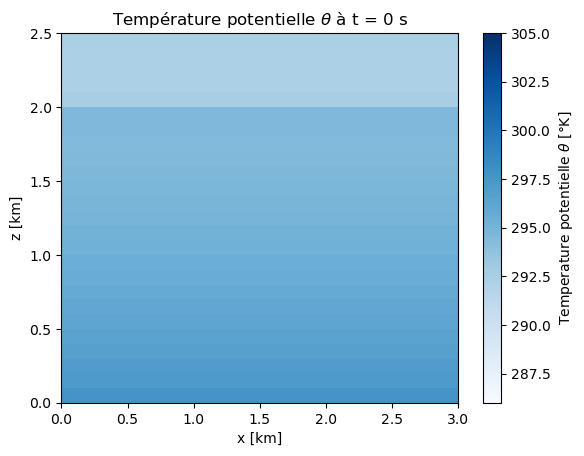

In [306]:
saison = 'été'         # saison pour définir le rayonnement du soleil

# Domaine
nx, nz = 15, 25                              # nombre de maille de la grille
Lx, Lz = 3000, 2500                          # taille du domaine 
dx, dz = Lx / nx, Lz / nz                    # largeur des mailles (résolution du modèle)
x = np.linspace(0, Lx, nx)                   # coordonnée horizontale
z = np.linspace(Lz/nz, Lz, nz)               # coordonnée verticale (altitude)
X, Z = np.meshgrid(x, z, indexing='ij')      # tableaux 2D de coordonnées

# Temps
t_init = 0 #h (UTC : solaire) de début de simulation
i_t = 0   #indice tu 1er pas de temps
dt = 50   # pas de temps du modèle (discrétisation du temps)
nt = int(14*3600/dt)  # nombre de pas de temps de la simulation (dt * nt = durée de la simulation)

# Constantes physiques
Rd = 287      # constant du gaz parfait de l'air sec
cp = 1004     # chaleur spécifique de l'air
Lv = 2.5e6    # chaleur latente de vaporisation [J/kg]
g = 9.81      # accélération de la pesanteur sur terre
kappa = 0.4   # constante de Von Karman
sigma = 5.670367 * 10**(-8)  # watt/m2, constante de Stefan-Boltzmann
tau_f = 60    # temps de relaxation pour la frixion du vent en surface

# Champs initiaux d'atmosphère
#Pression (constant au cours de la simulation)
p0 = 1.015e5                                                     # Pression du bas de l'atmosphère
p = p0 * np.exp(-z *np.log(1.4)/ Lz)                                # Profile de pression dans l'atmosphère
# Profil de température potentielle (K)
# Quasi neutre en basse couche, puis plus stable au-dessus
theta = 290 + 1 *z/1000
theta = theta[None,:] * np.ones((nx,nz))
# Profil d'humidité spécifique (kg/kg) 
# Humidité forte au sol, décroissance rapide
q = 0.014 * np.exp(-z / 1000)  # 14 g/kg au sol, ~5 g/kg à 1000 m, sec au-dessus
q = q[None,:] * np.ones((nx,nz))
q_l = np.zeros((nx, nz))                                     # eau liquide [kg/kg]
w = np.zeros((nx, nz))                                       # vitesse verticale ("grande échelle")
u = np.ones((nx, nz))                                 # vent horizontal initial dans l'atmosphère
Teff = 250      # Kelvin, température équivalente d'émission infrarouge de l'atmosphère
K = 0.01 * np.ones((nx,nz)) #mélange turbulent initial
rho = densite_air(p, theta, Rd, cp) #profil initial de densité de l'air

#Champs initiaux de surface
#Constants
albedo = np.zeros((nx))
emissivite = 0.95 * np.ones((nx))
rho_sol = 1400 * np.ones((nx)) #densité du sol
rho_surf_atmo = rho[:,0] #densité de l'air proche du sol
cp_sol = 1500 * np.ones((nx)) #capacité thermique à pression constante du sol
dz_sol = 0.1 #m épaisseur sol actif
z0_x =  0.05 * np.ones((nx))    #longueur de rugosite du sol
p_surf_atmo = p0 * np.ones((nx))                  #pression de surface
#Initiaux
theta_sol = theta0 * np.ones((nx))
q_sol = 0.00 * np.ones((nx))
Ksurf = K[:,0] #coeff turbulent pour les flux de surface
Ksurfmin = 0.05 #coeff turbulent minimal en surface (pour maitriser Tsol)

#On écrase les champs de surface avec les paramètres propres à un biotope
code_surface = np.ones_like(theta_sol)
surface(code_surface) #maj grandeurs sol pour prairie

# Paramètres pour l'animation graphique
fig, ax = plt.subplots()
img = ax.imshow(theta.T, origin='lower', extent=[0, Lx/1000, 0, Lz/1000],
                aspect='auto', cmap='Blues', vmin=286, vmax=305)
cb = plt.colorbar(img, ax=ax, label=r'Temperature potentielle $\theta$ [°K]')
ax.set_title('Temperature potentielle (melange vertical)')
ax.set_xlabel('x [km]')
ax.set_ylabel('z [km]')

#Tableaux de stockage de variables du modèle
dico_storage = {variable : np.zeros((nx,nz,nt+1), dtype=np.float32) for variable in ['theta', 'q', 'q_l', 'w', 'u', 'K']}
dico_storage['theta_sol'] = np.zeros((nx,nt+1),dtype=np.float32)
dico_storage['q_sol'] = np.zeros((nx,nt+1),dtype=np.float32)
dico_storage['Ksurf'] = np.zeros((nx,nt+1),dtype=np.float32)
    
def update_atmosphere(frame):
    global theta, q, q_l, w, u, theta_sol, q_sol, K, Ksurf, i_t #variables qui évoluent au cours du temps

    fluxsoleil = interpol_soleil(saison, t_init, dt, nt) #rayonnement du soleil à chaque pas de temps
    
    #sauvegarde les variables modèles à chaque pas de temps pour conserver tout l'historique
    if i_t < nt + 1: #erreur possitlbe de funanimation qui continue après nt+1
        dico_storage['theta'][:,:,i_t] = theta
        dico_storage['q'][:,:,i_t] = q
        dico_storage['q_l'][:,:,i_t] = q_l
        dico_storage['w'][:,:,i_t] = w
        dico_storage['u'][:,:,i_t] = u
        dico_storage['K'][:,:,i_t] = K
        dico_storage['theta_sol'][:,i_t] = theta_sol
        dico_storage['q_sol'][:,i_t] = q_sol
        dico_storage['Ksurf'][:,i_t] = Ksurf

        tempo_fluxsoleil = fluxsoleil[i_t]
    else :
        tempo_fluxsoleil = fluxsoleil[nt]
        print(f"Dépassement i_t={i_t} ! Ignoré.")
       
    #Mise à jour des vents: u et v
    #vent horizontal 
    u, w = respect_CFL(u, w, dx, dz, dt) #respect de la stabilité numérique
    u = vent_friction(u, z, z0_x, dt, Lz, tau_f=60, kappa=0.4) #Friction au sol
    #u = vent_heterogeneite_thermique(u,theta) #gradient thermique horizontal #désactivé
    
    # Vitesse verticale de grande échelle
    w = w_continuite(u, rho, dx, dz, w_bas=0)

    # Advection = mouvement par le vent
    theta = advection(u, w, rho, theta, dx, dz, dt)
    # #print('theta post adv', theta[:,0])
    q = advection(u, w, rho, q, dx, dz, dt)
    q_l = advection(u, w, rho, q_l, dx, dz, dt)
    w_copie = w.copy() #stockage de w avant son advection par lui même, pour utiliser l'ancien w dans l'advection de u
    w = advection(u, w, rho, w, dx, dz, dt)
    u = advection(u, w_copie, rho, u, dx, dz, dt)
    del w_copie

    # #Verifie que l'humidite est positive
    q, q_l = humidite_positive(q, q_l, theta, Lv, cp)

    # Mélange vertical par la turbulence / convection
    K = Kfunc(K, theta, theta_sol, u[:,0], Ksurf, z0_x, z, rho, rho_surf_atmo, cp, g, kappa, dz, dt, Ck=0.15)
    Ksurf = K[:,0]
    flux_sensible = flux_sensible_surface(theta, theta_sol, Ksurf, cp, rho_surf_atmo, dz)
    flux_evaporation = flux_evaporation_surface(Ksurf, p_surf_atmo, rho_surf_atmo, theta_sol, Rd, cp, q, q_sol, rho_sol, cp_sol, dz_sol, dz)
    theta = melange_turbulent(theta, K, rho, flux_sensible) #p_surf_atmo/(0.622 * cp)
    q = melange_turbulent(q, K, rho, flux_evaporation)
    q_l = melange_turbulent(q_l, K, rho)
    u = melange_turbulent(u, K, rho)
    w = melange_turbulent(w, K, rho)

    #Verifie que l'humidite est positive
    q, q_l = humidite_positive(q, q_l, theta, Lv, cp)

    #Ajustement à la saturation : condensation / evaporation
    q, q_l, theta = ajuste_saturation(q, q_l, p, theta, Lv, Rd, cp)

    #Mise à jour de la surface sous l'effet de l'atmosphère
    theta_sol, q_sol = update_surface(theta, theta_sol, q, q_sol, q_l, Lv, cp, Ksurf, dz, tempo_fluxsoleil, albedo, emissivite, Rd, sigma, p_surf_atmo, rho_surf_atmo, rho_sol, cp_sol, dz_sol, Teff)
    
    #Avancement du temps
    i_t += 1
    
    #Indication de l'avancement de la simulation 
    percent = 100 * (frame+1) / nt
    print(f"\rAvancement simulation : {percent:.1f} %", end='', flush=True)

    # Mise à jour du graphique
    img.set_data(theta.T)
    ax.set_title(rf'Température potentielle $\theta$ à t = {frame*dt:.0f} s')
    return [img]
    
start_time = time.time()
ani = FuncAnimation(fig, update_atmosphere, frames=nt, interval=100, blit=False,repeat=True)
HTML(ani.to_jshtml())
end_time = time.time()
print(f'Temps d\'éxécution : {(end_time - start_time):.2f} secondes')

## Diagnostiques température

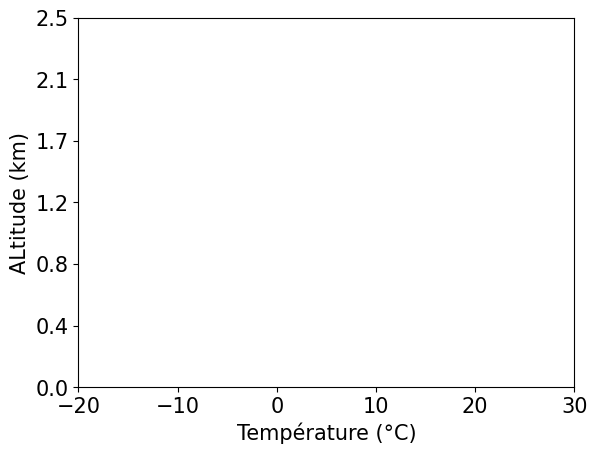

In [307]:
#Animation profil moyen de température
#NE PAS TOUCHER À CE CODE
freq = int(3600/dt)
z = np.linspace(0, Lz, nz)  # Hauteur en mètres
temperature = np.mean(dico_storage['theta'][:,:,::freq], axis=0)
for i in range(len(temperature[0])):
    temperature[:,i] = temperature[:,i] * exner(p, Rd, cp, pref=1e5) - 273.15

# --- Création de la figure ---
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(-20,30)        # Adapter selon l’échelle de tes données
ax.set_yticks(z[::4], np.round(z/1000, 1)[::4])
ax.set_ylabel('ALtitude (km)', fontsize=15)
ax.set_xlabel('Température (°C)', fontsize=15)
ax.tick_params(labelsize=15)
title = ax.set_title("")

# --- Fonction d'initialisation (appelée une fois) ---
def init():
    line.set_data([], [])
    title.set_text("")
    return line, title

# --- Fonction de mise à jour à chaque image ---
def update(frame):
    line.set_data(temperature[:, frame], z)
    title.set_text(f"Temps depuis init= {frame}H")
    return line, title

# --- Création de l'animation ---
ani = FuncAnimation(fig, update, frames=len(temperature[0]), init_func=init,
                    blit=False, interval=100)
HTML(ani.to_jshtml())

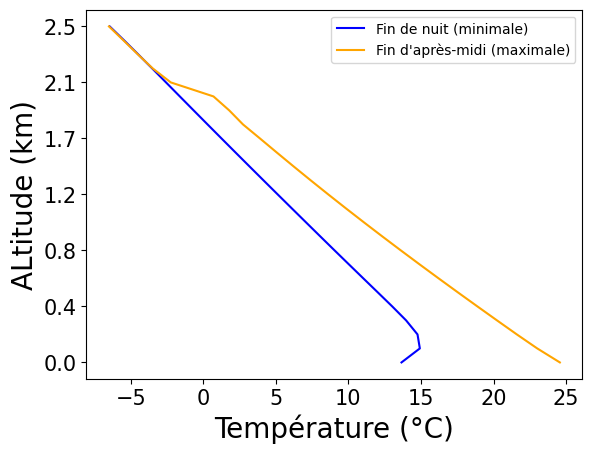

In [311]:
#Comparatif des profils de températures lorsque la température du 1er niveau d'atmosphère atteint ses extrêmes (minimale / maximale)
#NE PAS TOUCHER À CE CODE
fig, ax = plt.subplots()
i_t_min = np.argmin(temperature[0])
i_t_max = np.argmax(temperature[0])
ax.plot(temperature[:,i_t_min], z, color='blue', label='Fin de nuit (minimale)')
ax.plot(temperature[:,i_t_max], z, color='orange', label='Fin d\'après-midi (maximale)')
ax.legend()
ax.set_yticks(z[::4], np.round(z/1000, 1)[::4])
ax.set_ylabel('ALtitude (km)', fontsize=20)
ax.set_xlabel('Température (°C)', fontsize=20)
ax.tick_params(labelsize=15)

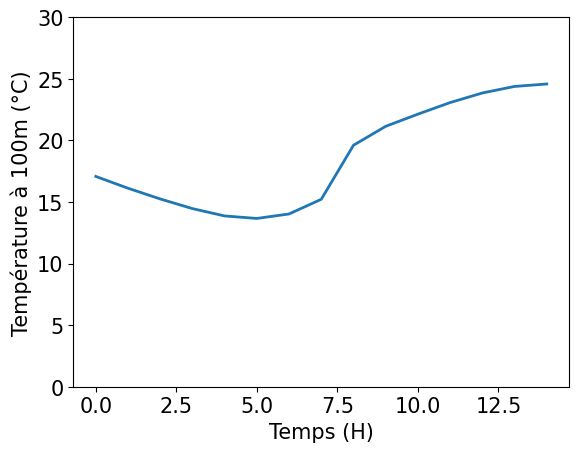

In [314]:
#Courbe de température du 1er niveau d'atmosphère
#utilise la cellule précédente pour le calcul de la température dans l'atmosphère
#NE PAS TOUCHER À CE CODE
freq = int(3600/dt)
z = np.linspace(0, Lz, nz)  # Hauteur en mètres
temperature = np.mean(dico_storage['theta'][:,:,::freq], axis=0)
for i in range(len(temperature[0])):
    temperature[:,i] = temperature[:,i] * exner(p, Rd, cp, pref=1e5) - 273.15


# --- Création de la figure ---
fig, ax = plt.subplots()
ax.plot(temperature[0], lw=2)
ax.set_ylim(0,30)       
ax.set_ylabel('Température à '+ str(int(dz)) + 'm (°C)', fontsize=15)
ax.set_xlabel('Temps (H)', fontsize=15)
ax.tick_params(labelsize=15)

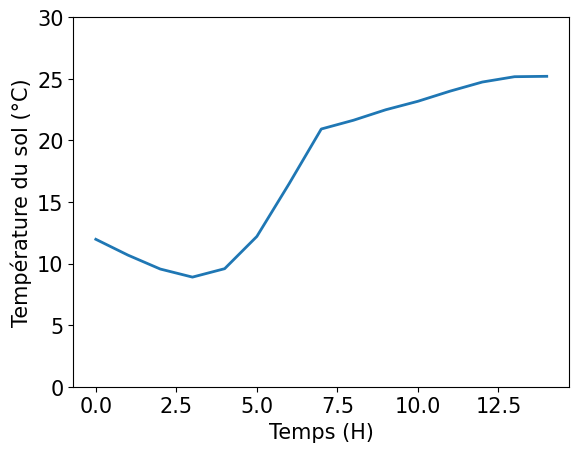

In [313]:
#Courbe de température du sol
#NE PAS TOUCHER A CE CODE
freq = int(3600/dt)
z = np.linspace(0, Lz, nz)  # Hauteur en mètres
theta_sol = np.mean(dico_storage['theta_sol'][:,::freq], axis=0)
temperature_sol = theta_sol * exner(p[0], Rd, cp, pref=1e5) - 273.15


# --- Création de la figure ---
fig, ax = plt.subplots()
ax.plot(temperature_sol, lw=2)
ax.set_ylim(0,30)       
ax.set_ylabel('Température du sol (°C)', fontsize=15)
ax.set_xlabel('Temps (H)', fontsize=15)
ax.tick_params(labelsize=15)

## Animations profile (1D), coupe (2D) des autres variables

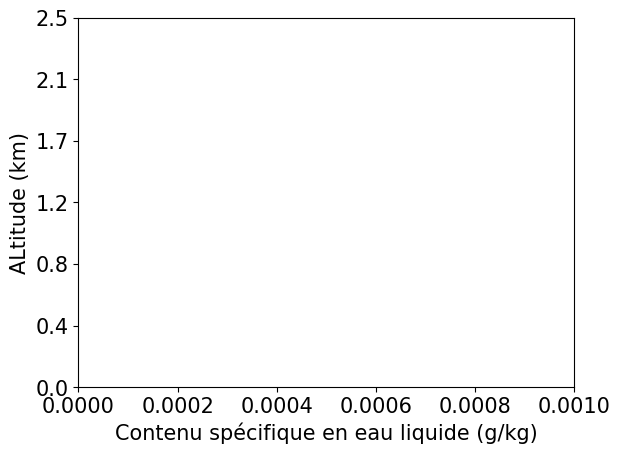

In [312]:
#Animation profile vertical moyen
#variable parmi : 'q', 'q_l', 'w', 'u', 'K'
#A EDITER SELON VARIABLE CHOISIE
variable = 'q_l'
vmin, vmax = 0, 0.001
label = 'Contenu spécifique en eau liquide (g/kg)' #titre de l'ordonnée au format 'variable (unité)'
data = np.mean(dico_storage[variable][:,:,::freq], axis=0)*1000
freq = int(3600/dt)
z = np.linspace(0, Lz, nz)  # Hauteur en mètres


#NE PAS TOUCHER À LA SUITE
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(vmin, vmax)     
ax.set_yticks(z[::4], np.round(z/1000, 1)[::4])
ax.set_ylabel('ALtitude (km)', fontsize=15)
ax.set_xlabel(label, fontsize=15) # ADAPTER SELON LA VARIABLE CHOISIE
ax.tick_params(labelsize=15)
title = ax.set_title("")

# --- Fonction d'initialisation (appelée une fois) ---
def init():
    line.set_data([], [])
    title.set_text("")
    return line, title

# --- Fonction de mise à jour à chaque image ---
def update(frame):
    line.set_data(data[:, frame], z)
    title.set_text(f"Temps depuis init= {frame}H")
    return line, title

# --- Création de l'animation ---
ani = FuncAnimation(fig, update, frames=len(data[0]), init_func=init,
                    blit=False, interval=100)
HTML(ani.to_jshtml())

In [278]:
np.where(dico_storage['q_l'])

(array([ 0,  0,  0, ..., 14, 14, 14]),
 array([ 0,  0,  0, ..., 12, 12, 12]),
 array([  1,   3,   5, ..., 544, 546, 548]))

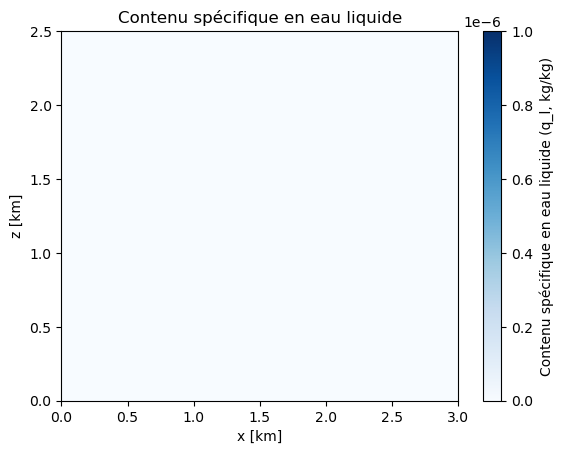

In [310]:
#animation 2D
#variable parmi : 'q', 'q_l', 'w', 'u', 'K'
#A EDITER SELON LA VARIABLE CHOISIE
variable = 'q_l'
vmin, vmax = 0, 0.000001
title1 = 'Contenu spécifique en eau liquide'
colorbar_label = r'Contenu spécifique en eau liquide (q_l, kg/kg)'


#NE PAS TOUCHER À LA SUITE
freq = int(3600/dt)
data = dico_storage[variable][:,:,::freq]
# print(data.max())
# bug

z = np.linspace(0, Lz, nz)  # Hauteur en mètres
# --- Création de la figure ---
# Paramètres pour l'animation graphique
fig, ax = plt.subplots()
img = ax.imshow(theta.T, origin='lower', extent=[0, Lx/1000, 0, Lz/1000],
                aspect='auto', cmap='Blues', vmin=vmin, vmax=vmax)
cb = plt.colorbar(img, ax=ax, label=colorbar_label)
ax.set_title(title1)
ax.set_xlabel('x [km]')
ax.set_ylabel('z [km]')

# --- Fonction d'initialisation (appelée une fois) ---
def init():
    img.set_data(data[:,:,0].T)
    title.set_text("")
    return [img]

# --- Fonction de mise à jour à chaque image ---
def update(frame):
    img.set_data(data[:,:,frame].T)
    title.set_text(f"Temps depuis init= {frame}H")
    return [img]

# --- Création de l'animation ---
ani = FuncAnimation(fig, update, frames=len(data[0,0]), init_func=init,
                    blit=False, interval=100)
HTML(ani.to_jshtml())